<a href="https://colab.research.google.com/github/seeedata/LG-Aimers/blob/main/GRU%20Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 전체데이터를 돌리는데 Loss Function을 MSE로 두고 이를 낮추는 방향으로 학습.

# Dataset Info.

- train.csv
> - ID : 실제 판매되고 있는 고유 ID
> - 제품 : 제품 코드
> - 대분류 : 제품의 대분류 코드
> - 중분류 : 제품의 중분류 코드
> - 소분류 : 제품의 소분류 코드
> - 브랜드 : 제품의 브랜드 코드
> - **2022-01-01 ~ 2023-04-04 : 실제 일별 판매량**
> - 단, 제품이 동일하여도 판매되고 있는 고유 ID 별로 기재한 분류 정보가 상이할 수 있음. 즉, 고유 ID가 다르다면, 제품이 같더라도 다른 판매 채널


- sample_submission.csv - 제출 양식
> - ID : 실제 판매되고 있는 고유 ID (제출 시 ID Column에 해당하는 데이터에 반드시 zfill(5)를 적용할 필요 없음)
> - **2023-04-05 ~ 2023-04-25 : 예측한 일별 판매량**


- sales.csv - 메타(Meta) 정보
> - ID : 실제 판매되고 있는 고유 ID
> - 제품 : 제품 코드
> - 대분류 : 제품의 대분류 코드
> - 중분류 : 제품의 중분류 코드
> - 소분류 : 제품의 소분류 코드
> - 브랜드 : 제품의 브랜드 코드
> - **2022-01-01 ~ 2023-04-04 : 실제 일별 총 판매금액**
> - 단, 제품이 동일하여도 판매되고 있는 고유 ID 별로 기재한 분류 정보가 상이할 수 있음. 즉, 고유 ID가 다르다면, 제품이 같더라도 다른 판매 채널


- brand_keyword_cnt.csv - 메타(Meta) 정보
> - 브랜드 : 브랜드 코드
> - 2022-01-01 ~ 2023-04-04 : 브랜드의 연관키워드 언급량을 정규화한 일별 데이터

- product_info.csv - 메타(Meta) 정보
> - 제품 : 제품 코드
> - 제품특성 : 제품 특성 데이터(Text)
> - train.csv에 존재하는 모든 제품 코드가 포함되어 있지 않음. 또는 product_info.csv에 존재하는 제품 코드가 train.csv에 존재하지 않을 수 있음.


# 1. Dataset Load
- Scaled Dataset은 Scaling 소요 시간으로 인해 따로 저장했음.
- 모델 돌릴 때는 GPU로 작업하시고, 다른 변수 탐색 시에는 CPU로 사용해주세요. (나중에 GPU 사용 제한량 걸립니다.ㅜㅜ)
- 제가 공유드린 **'LG_AImers_Hackerthon'** 폴더 사용해주세요!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np

brand_keyword = pd.read_csv('/content/drive/MyDrive/LG Aimers/data/brand_keyword_cnt.csv', encoding='cp949')  #브랜드 일별 언급량 정규화
brand_keyword_scaled = pd.read_csv('/content/drive/MyDrive/LG Aimers/data/brand_keyword_scaled.csv')  #브랜드 일별 언급량 Min_Max_Scaled
product_info = pd.read_csv('/content/drive/MyDrive/LG Aimers/data/product_info.csv')
sales = pd.read_csv('/content/drive/MyDrive/LG Aimers/data/sales.csv', encoding='cp949')  #실제 일별 판매 금액
submission = pd.read_csv('/content/drive/MyDrive/LG Aimers/data/sample_submission.csv')
train = pd.read_csv('/content/drive/MyDrive/LG Aimers/data/train.csv', encoding='cp949')  #실제 일별 판매량
train_scaled = pd.read_csv('/content/drive/MyDrive/LG Aimers/data/train_scaled.csv')  #일별 판매량 Min_Max_Scaled

In [6]:
#브랜드 전체 평균 계산
brand_mean = pd.concat([brand_keyword_scaled['브랜드'], brand_keyword_scaled.iloc[:, 1:].mean(axis = 1)], axis = 1)
brand_mean.columns = ['brand', 'brand_mean']

In [7]:
## '소분류' 열에 대해 Label Encoding 진행
## 전체 train set에 대해서 소분류 Label Encoding fit한 후 데이터를 분리해야 함.

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

categorical_columns = ['소분류']
for col in categorical_columns:
    label_encoder.fit(train_scaled[col])
    train_scaled[col] = label_encoder.transform(train_scaled[col])


## '브랜드' 열을 기준으로 train_scaled 데이터셋에 브랜드 평균 값 추가

tmp_br = pd.merge(train_scaled[['ID', '브랜드']], brand_mean, left_on = '브랜드', right_on = 'brand')
#train_scaled 5열에 brand_mean 변수 추가
train_scaled.insert(loc = 5, column = 'brand_mean', value = tmp_br['brand_mean'] )
#train_scaled에서 브랜드 열 제거
train_scaled = train_scaled.drop(['브랜드'], axis = 1)
#brand_mean의 결측치는 brand_mean 전체 평균으로 넣음 (fillna)
train_scaled['brand_mean'] = train_scaled['brand_mean'].fillna(train_scaled['brand_mean'].mean())
train_scaled.drop(['제품','중분류', '대분류'], axis = 1, inplace=True); train_scaled.head()

,ID,소분류,brand_mean,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,37,0.177865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,1,43,0.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111111,0.333333,0.222222,0.0,0.0,0.222222,0.0
2,2,43,0.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,3,43,0.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,4,2,0.013591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


# 2. Modeling - Keras GRU
- 참고: https://www.kaggle.com/code/humamfauzi/multiple-stock-prediction-using-single-nn#Gated-Recurrent-Units

- 데이터 조정 참고: https://dacon.io/competitions/official/236129/codeshare/8668?page=1&dtype=recent

In [8]:
CFG = {
    'TRAIN_WINDOW_SIZE':60,  #학습 윈도우의 크기. 60일치를 학습에 사용
    'PREDICT_SIZE':21,  #예측 윈도우의 크기. 다음 21일치를 예측
    'LEARNING_RATE':5e-4,
    'SEED':9083  #모델 재현성을 위해 Seed 고정
}

In [9]:
## Seed 고정 후 진행

import random
import os
import tensorflow as tf

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything(CFG['SEED'])  #Seed 고정

In [10]:
from tqdm.auto import tqdm

## 데이터를 학습에 사용할 수 있는 형태로 변환

def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):  #data에 ID 열 지운 데이터를 넣을 것임
    STEP_SIZE = 2  #이 값을 본인의 환경에 맞게 조정

    #데이터의 행 수
    num_rows = len(data)
    #각 윈도우의 크기
    window_size = train_size + predict_size
    #데이터셋에서 윈도우를 이동시켜야 하는 횟수. 데이터셋을 윈도우 크기로 얼마나 나눌 수 있는지. 윈도우 개수
    #각 윈도우는 한 행에 대해서만 적용
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    #입력 데이터를 저장할 빈 배열.
    #(전체 데이터에서 윈도우 개수, 각 윈도우에서 사용할 입력 데이터의 크기, encode_info와 window[:train_size]를 np.column_stack으로 결합한 결과인 열 3개)
    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :2]) + 1))
    #타겟 데이터를 저장할 빈 배열. (전체 데이터에서의 윈도우 개수, 각 윈도우에서 예측해야 하는 데이터의 크기)
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    #data의 각 행에 대해
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :2])  #'소분류', 'brand_mean' 열 저장
        sales_data = np.array(data.iloc[i, 2:])  #일별 판매량 열 저장

        #len(sales_data): 일별 판매량 열 개수
        #220101부터 step size 간격으로 윈도우를 이동
        #현재 윈도우에 대해
        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            #현재 윈도우의 데이터를 선택해 'window'에 저장
            window = sales_data[j: j + window_size]
            #np.tile -> encode_info를 반복해서 (train_size, 1) 크기로 만든다
            #이 encode_info를 train_size까지의 윈도우랑 세로로 결합
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            #input data에 temp_data 저장
            #[] 안의 수는 input data의 어디에 놓일 지 지정해 줌
            input_data[i * adjusted_size + j // STEP_SIZE] = temp_data
            #target data에 window의 target 부분이 저장
            #[] 안의 수는 window data의 어디에 놓일 지 지정해 줌
            target_data[i * adjusted_size + j // STEP_SIZE] = window[train_size:]

    return input_data, target_data

In [11]:
## 평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
## data : 'ID' 열 지운 데이터
## train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)

def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):

    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :2]) + 1))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :2])
        #각 행에서 마지막 'train_size'개의 데이터를 'sales_data'에 저장
        sales_data = np.array(data.iloc[i, -train_size:])
        #'sales_data'에서 마지막 'train_size'개의 데이터를 'window'에 저장
        window = sales_data[-train_size:]

        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data

    return input_data

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM
from tensorflow.keras.activations import linear
from tensorflow.keras.optimizers import Adam

#ouput_window: 모델이 출력으로 반환하는 윈도우 크기
#inputs: 모델의 입력 데이터
def GRU_Model(output_window, inputs):
   opt = tf.keras.optimizers.legacy.Adam(learning_rate = CFG['LEARNING_RATE'])
   model = Sequential()
   #64개 unit. 시퀀스 반환 안함.
   model.add(GRU(64, return_sequences = False, input_shape=(inputs.shape[1], 3)))
   model.add(Dense(32, activation = linear))
   model.add(Dropout(0.2))
   model.add(Dense(output_window, activation = linear))
   model.compile(optimizer = opt, loss='mean_squared_error')
   model.summary()
   return model

## 2.1 PSFA Score Callback Function

In [ ]:
import numpy as np

## '대분류'에 따라 인덱스를 그룹화하여 딕셔너리에 저장

indexs_bigcat = {}
for bigcat in train_scaled['대분류'].unique():
    indexs_bigcat[bigcat] = list(train_scaled.loc[train_scaled['대분류']==bigcat].index)


## PSFA 점수 계산

def psfa_score(y_true, y_pred):

    #PSFA를 1.0으로 초기화
    PSFA = tf.constant(1.0, dtype=tf.float32)

    #y_pred를 tf의 텐서로 변환
    y_pred = tf.convert_to_tensor(y_pred)
    #y_true는 y_pred와 동일한 데이터 타입으로 캐스팅
    #텐서플로에서 연산을 수행할 때, 데이터 타입이 일치해야 하기 때문
    y_true = tf.cast(y_true, y_pred.dtype)

    #딕셔너리에 저장된 각 '대분류'에 대하여
    for cat in indexs_bigcat.keys():
        #해당 대분류에 속하는 행의 인덱스를 ids에 저장
        ids = indexs_bigcat[cat]

        #21일치 중 각 일에 대하여
        for day in range(21):
            #tf_gather(): y_true에서 ids에 저장된 인덱스에 해당하는 요소를 첫 번째 축을 기준으로 가져옴
            #해당 대분류의 특정 일자의 총 판매량
            total_sell = tf.reduce_sum(tf.gather(y_true, indices=ids, axis=0)[:, day])
            #해당 대분류의 특정 일자의 예측값
            pred_values = tf.gather(y_pred, indices=ids, axis=0)[:, day]
            #해당 대분류의 특정 일자의 실제값
            target_values = tf.gather(y_true, indices=ids, axis=0)[:, day]

            #실제값과 예측값 중 더 큰 값이 분모가 됨
            denominator = tf.maximum(target_values, pred_values)
            #분모가 0이 아니면 실제값과 예측값의 차이를 계산한 후, 분모로 나눠서 diffs에 저장
            #분모가 0이면 0을 diffs에 저장
            diffs = tf.where(denominator != 0, tf.abs(target_values - pred_values) / denominator, 0)

            if total_sell != 0:
                    sell_weights = target_values / total_sell
            else:
                #len(ids) 크기에 1로 채워진 텐서 생성
                #이를 len(ids)로 나눠줌
                sell_weights = tf.ones(shape=(len(ids),), dtype=tf.float32) / tf.cast(len(ids), dtype=tf.float32)

            nan_mask = tf.math.is_nan(diffs)
            #diffs에 nan이 포함되어 있지 않다면 PSFA를 계산
            if not tf.reduce_any(nan_mask):
                PSFA -= tf.reduce_sum(diffs * sell_weights) / (21 * 5)

    return PSFA

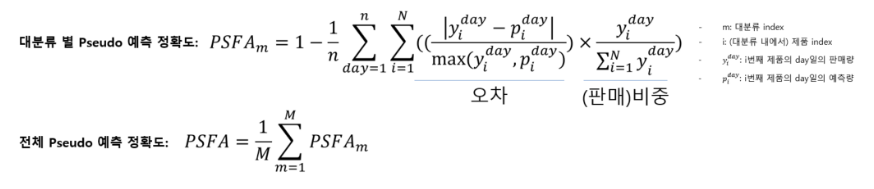

In [14]:
from tensorflow.keras.callbacks import Callback

## 각 Epoch가 끝날 때 PSFA값을 계산하고 출력하는 함수

class CustomMetricsCallback(Callback):  #Keras의 Callback 클래스를 상속

    def __init__(self, validation_data):

        #CustomMetricsCallback 클래스의 인스턴스가 생성될 때, Callback 클래스의 초기화 메서드를 호출하여 해당 클래스의 속성이나 초기화 코드 등을 상속함
        #CustomMetricsCallback 클래스는 Callback 클래스의 모든 속성과 기능을 포함하면서도 추가적인 기능을 정의할 수 있게 됨.
        super(CustomMetricsCallback, self).__init__()
        self.validation_data = validation_data

    ## Epoch가 끝날 때 호출되는 메서드
    ## epoch: 현재 에포크의 숫자
    ## logs: 에포크의 로그 값들을 포함
    def on_epoch_end(self, epoch, logs=None):

        # 마지막 Epoch에서만 값을 계산하도록 수정. 반복적으로 계산하는 경우 RAM이 폭파되기 때문.
        if epoch == self.params['epochs'] - 1:
          x_val, y_val = self.validation_data
          predictions = self.model.predict(x_val)
          PSFA_score = psfa_score(y_true = y_val, y_pred = predictions)
          print(f'Validation PSFA at end of epoch {epoch + 1}: {PSFA_score:.4f}')

## 2.2 위 과정을 한 번에 처리하는 함수



In [15]:
import gc

def full_inference(data, output_window = 21, output_file_name = 'set', batch_size = 1024):

    ## Train/Test set 준비
    train_input, train_target = make_train_data(data.drop(['ID'], axis = 1))
    test_input = make_predict_data(data.drop(['ID'], axis = 1))


    ## Train / Validation Split
    data_len = len(train_input)
    #데이터 길이의 20%를 검증 set으로 사용
    val_s_input = train_input[-int(data_len*0.2):]
    val_s_target = train_target[-int(data_len*0.2):]
    #검증 데이터가 아닌 부분은 train set으로 사용
    train_s_input = train_input[:-int(data_len*0.2)]
    train_s_target = train_target[:-int(data_len*0.2)]


    ## Setting Model
    #PSFA Score Callback
    custom_metrics_callback = CustomMetricsCallback(validation_data = (val_s_input, val_s_target))
    gru_model = GRU_Model(output_window = output_window, inputs = train_input)
    gru_model.fit(train_s_input, train_s_target, validation_data = (val_s_input, val_s_target), epochs = 10, batch_size = 1024, callbacks = [custom_metrics_callback])


    ## Prediction
    pred = gru_model.predict(test_input)
    pd.DataFrame(pred).to_csv('/content/drive/MyDrive/LG Aimers/data/' + output_file_name + '_pred.csv')
    gru_model.save('/content/drive/MyDrive/LG Aimers/data/ '+ output_file_name + '_model.h5')


    ## 메모리 관리
    #메모리에서 변수 삭제
    del train_input, train_target, test_input, val_s_input, val_s_target, train_s_input, train_s_target
    #파이썬의 garbage collector를 호출하여 더 이상 참조되지 않는 메모리를 해제
    gc.collect()

In [ ]:
import gc
gc.collect()

full_inference(data = train_scaled.drop(['제품', '중분류', '대분류'], axis = 1), output_window = 21, output_file_name = 'all_set', batch_size = 1024)

# 3. Prediction

## Inverse Scaling

- Scaling 시 얻었던 Min_Max 값들을 Load 후 Inverse Scaling

In [ ]:
import pickle

with open("/content/drive/MyDrive/LG_AImers_Hackerthon/scale_max_dict.pkl", 'rb') as file:
    scale_max_dict = pickle.load(file)

with open("/content/drive/MyDrive/LG_AImers_Hackerthon/scale_min_dict.pkl", 'rb') as file:
    scale_min_dict = pickle.load(file)

In [ ]:
result = pd.read_csv('/content/drive/MyDrive/LG_AImers_Hackerthon/all_set_pred.csv')
result.columns = submission.columns

In [ ]:
result

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,-0.012654,-0.004525,0.009050,0.014553,0.017212,0.016130,0.017245,0.014998,0.016490,...,0.022452,0.023703,0.021869,0.019815,0.019372,0.020514,0.023977,0.025900,0.026357,0.026306
1,1,0.039265,0.057517,0.080489,0.084257,0.085346,0.085753,0.085901,0.088180,0.089113,...,0.085927,0.086120,0.087116,0.088148,0.088818,0.088804,0.087309,0.087094,0.086825,0.087317
2,2,-0.009164,-0.001212,0.011500,0.016783,0.019675,0.018383,0.018825,0.016204,0.017036,...,0.023338,0.024748,0.022791,0.019934,0.019462,0.020217,0.023481,0.025721,0.026897,0.026274
3,3,-0.009164,-0.001212,0.011500,0.016783,0.019675,0.018383,0.018825,0.016204,0.017036,...,0.023338,0.024748,0.022791,0.019934,0.019462,0.020217,0.023481,0.025721,0.026897,0.026274
4,4,0.002699,0.005098,0.008242,0.009621,0.010560,0.009322,0.012659,0.011657,0.013410,...,0.015840,0.017356,0.017189,0.016695,0.016566,0.015334,0.016145,0.017325,0.018835,0.020747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,-0.005605,0.000318,0.011638,0.016738,0.019420,0.018889,0.019641,0.016749,0.017260,...,0.022911,0.024802,0.022898,0.019810,0.018791,0.019205,0.022352,0.024610,0.025713,0.025413
15886,15886,0.019833,0.023631,0.031067,0.035223,0.037521,0.037332,0.036933,0.033681,0.033064,...,0.038467,0.040036,0.038102,0.034453,0.032826,0.033332,0.036097,0.038761,0.039674,0.038919
15887,15887,-0.008963,-0.000904,0.011881,0.017210,0.020124,0.018906,0.019338,0.016770,0.017555,...,0.023781,0.025233,0.023368,0.020513,0.019984,0.020671,0.023901,0.026178,0.027428,0.026888
15888,15888,0.090300,0.078340,0.068658,0.066020,0.066656,0.066738,0.067806,0.065183,0.062910,...,0.063831,0.064871,0.065150,0.063580,0.061881,0.060242,0.060561,0.061921,0.063191,0.063824


In [ ]:
# inverse scaling
from tqdm.auto import tqdm

pred = pd.DataFrame(result)
for idx in range(len(pred)):
    pred.iloc[idx, 1:] = pred.iloc[idx, 1:] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

round_pred = np.round(pred, 0).astype(int)

In [ ]:
#하한 값을 0으로 설정
round_pred = round_pred.clip(lower = 0)

In [ ]:
round_pred

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,3,0,0,1,1,2,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
4,4,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,0,0,2,3,3,3,3,3,3,...,4,4,4,3,3,3,3,4,4,4
15886,15886,2,3,4,4,5,5,5,4,4,...,5,5,5,4,4,4,4,5,5,5
15887,15887,0,0,0,0,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
15888,15888,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
#최종 결과물 저장
round_pred.to_csv('submission14.csv', index = False)